# Package Installation

In [7]:
!pip install -qU transformers sentence-transformers datasets faiss-cpu openai pandas nltk scikit-learn evaluate python-terrier streamlit ir_datasets

In [98]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.3 MB/s eta 0:00:00


# Imports

In [124]:
import pyterrier as pt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import os
import shutil
import warnings
import time
import re
import itertools as it

In [125]:
warnings.filterwarnings("ignore")

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [126]:
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    print("NLTK 'punkt' and 'stopwords' resources found.")
except LookupError:
    print("Downloading NLTK 'punkt' and 'stopwords'...")
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    print("NLTK resources downloaded.")
nltk_stop_words_for_sbert = set(stopwords.words('english'))

NLTK 'punkt' and 'stopwords' resources found.


In [11]:
if not pt.java.started():
    pt.java.init()

terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


In [12]:
nltk_stop_words = set(stopwords.words('english'))
stemmer = nltk.PorterStemmer()

# Constant Parameters

In [129]:
DOC_SUBSET_SIZE = 50000
QUERY_SUBSET_SIZE_EVAL = 10
CANDIDATES_FOR_RERANK_MONOBERT_EVAL = 10
CANDIDATES_FOR_RERANK_DUOBERT_EVAL = 10
CANDIDATES_FOR_RERANK_DEMO = 10

## Nerual Expander  

In [29]:
NQE_MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
NQE_MAX_CANDIDATE_TERMS = 50
NQE_NUM_EXP_DOCS = 5
NQE_EXP_TERMS_COUNT = 3

# Bert Re-ranker

In [30]:
BERT_MODEL_NAME = 'bert-base-uncased'
MONOBERT_BATCH_SIZE = 16
MONOBERT_MAX_LENGTH = 256
DUOBERT_BATCH_SIZE = 4
DUOBERT_MAX_LENGTH = 384

# Data Loading

In [31]:
dataset_name = 'irds:cord19/trec-covid'
dataset = pt.get_dataset(dataset_name)

In [32]:
queries_df_orig_full = dataset.get_topics()
qrels_df_orig_full = dataset.get_qrels()

There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


In [34]:
queries_df_orig_full['qid'] = queries_df_orig_full['qid'].astype(str)
qrels_df_orig_full['qid'] = qrels_df_orig_full['qid'].astype(str)
qrels_df_orig_full['docno'] = qrels_df_orig_full['docno'].astype(str)
if 'label' in qrels_df_orig_full.columns:
    qrels_df_orig_full['label'] = qrels_df_orig_full['label'].astype(int)

Original CORD-19 queries: 50
Original CORD-19 qrels: 69318


,qid,docno,label,iteration
0,1,005b2j4b,2,4.5
1,1,00fmeepz,1,4
2,1,010vptx3,2,0.5
3,1,0194oljo,1,2.5
4,1,021q9884,1,4


In [127]:
print(f"Original CORD-19 queries loaded: {len(queries_df_orig_full)}")
print(f"Original CORD-19 qrels loaded: {len(qrels_df_orig_full)}")

Original CORD-19 queries loaded: 50
Original CORD-19 qrels loaded: 69318


In [130]:
print(f"Loading first {DOC_SUBSET_SIZE} documents from CORD-19 corpus to form the primary document set...")
docs_for_subset_list = list(it.islice(dataset.get_corpus_iter(), DOC_SUBSET_SIZE))

Loading first 50000 documents from CORD-19 corpus to form the primary document set...


cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]

In [131]:
if not docs_for_subset_list:
    print("CRITICAL: No documents could be loaded from corpus iterator. Index will be empty.")
    documents_df_subset = pd.DataFrame(columns=['docno', 'text'])
else:
    documents_df_subset = pd.DataFrame(docs_for_subset_list)

In [132]:
if not documents_df_subset.empty:
    if 'doc_id' in documents_df_subset.columns and 'docno' not in documents_df_subset.columns:
        documents_df_subset.rename(columns={'doc_id': 'docno'}, inplace=True)
    documents_df_subset['docno'] = documents_df_subset['docno'].astype(str)

    if 'text' not in documents_df_subset.columns:
        if 'title' in documents_df_subset.columns and 'abstract' in documents_df_subset.columns:
            documents_df_subset['text'] = documents_df_subset['title'].fillna('') + " " + documents_df_subset['abstract'].fillna('')
        elif 'title' in documents_df_subset.columns:
             documents_df_subset['text'] = documents_df_subset['title'].fillna('')
        else:
            print("Warning: 'text' column missing in documents_df_subset and could not be constructed. Using empty strings.")
            documents_df_subset['text'] = ""
    documents_df_subset['text'] = documents_df_subset['text'].astype(str).fillna("")
else:
    print("Warning: docs_for_subset_list was empty. documents_df_subset is empty.")
    documents_df_subset = pd.DataFrame(columns=['docno', 'text'])

In [133]:
documents_df_orig = documents_df_subset.copy()
print(f"Created `documents_df_subset` (for indexing) and `documents_df_orig` (for text lookup) with {len(documents_df_subset)} documents.")

Created `documents_df_subset` (for indexing) and `documents_df_orig` (for text lookup) with 50000 documents.


In [135]:
qrels_df_subset = qrels_df_orig_full[qrels_df_orig_full['docno'].isin(documents_df_subset['docno'])].copy()

valid_qids_for_subset = qrels_df_subset['qid'].unique()
queries_df_subset = queries_df_orig_full[queries_df_orig_full['qid'].isin(valid_qids_for_subset)].copy()

In [136]:
qrels_df_subset = qrels_df_subset[qrels_df_subset['qid'].isin(queries_df_subset['qid'])].copy()


In [137]:
print(f"Aligned operational subset counts: "
      f"documents indexed (documents_df_subset): {len(documents_df_subset)}, "
      f"queries with relevant docs in index (queries_df_subset): {len(queries_df_subset)}, "
      f"qrels for these (qrels_df_subset): {len(qrels_df_subset)}")

Aligned operational subset counts: documents indexed (documents_df_subset): 50000, queries with relevant docs in index (queries_df_subset): 50, qrels for these (qrels_df_subset): 8410


In [138]:
if documents_df_subset.empty :
    print("CRITICAL FALLBACK: documents_df_subset is empty. Adding dummy doc for index.")
    documents_df_subset = pd.DataFrame([{'docno': 'dummy_doc_final_idx', 'text': 'final dummy doc text for index'}])
    documents_df_orig = documents_df_subset.copy()
if queries_df_subset.empty:
    print("FALLBACK: queries_df_subset is empty. Adding dummy query for operations.")
    queries_df_subset = pd.DataFrame([{'qid': 'dummy_qid_final_ops', 'query': 'final dummy query for ops'}])
    qrels_df_subset = pd.DataFrame(columns=['qid', 'docno', 'label'])
if qrels_df_subset.empty and not queries_df_subset.empty and not (len(queries_df_subset)==1 and queries_df_subset.iloc[0]['qid'] == 'dummy_qid_final_ops'):
    print("NOTE: qrels_df_subset is empty, but queries_df_subset exists (and is not dummy). Evaluation will find no relevant items.")

if 'text' not in documents_df_subset.columns:
     documents_df_subset['text'] = ""
documents_df_subset['text'] = documents_df_subset['text'].fillna("")

In [140]:
def preprocess_document_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)
    processed_tokens = [stemmer.stem(word) for word in tokens if word not in nltk_stop_words and word.isalpha()]
    return ' '.join(processed_tokens)

In [141]:
if not documents_df_subset.empty:
    documents_df_subset['processed_text'] = documents_df_subset['text'].apply(preprocess_document_text)
    if not documents_df_subset.empty and 'text' in documents_df_subset.columns and len(documents_df_subset.iloc[0]['text']) > 0 :
        print("Sample preprocessed document:")
        print(f"Original: {documents_df_subset.iloc[0]['text'][:200]}")
        print(f"Processed: {documents_df_subset.iloc[0]['processed_text'][:200]}")
    else:
        print("Sample document is empty or not available for display after preprocessing attempt.")
else:
    print("documents_df_subset is empty. Skipping preprocessing display.")
    if 'processed_text' not in documents_df_subset.columns:
        documents_df_subset['processed_text'] = ""

Sample preprocessed document:
Original: Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia OBJECTIVE: This retrospective chart review describes the epidemiology a
Processed: clinic featur cultureproven mycoplasma pneumonia infect king abdulaziz univers hospit jeddah saudi arabia object retrospect chart review describ epidemiolog clinic featur patient cultureproven mycopla


In [142]:
index_path = "./cord19_index_phased_notebook_corrected_v3"
if os.path.exists(index_path):
    shutil.rmtree(index_path)

In [143]:
if not documents_df_subset.empty and 'processed_text' in documents_df_subset.columns:
    docs_for_indexing = documents_df_subset[['docno', 'processed_text']].rename(
        columns={'processed_text': 'text'}
    ).to_dict(orient='records')
    if not docs_for_indexing:
        print("Warning: docs_for_indexing is an empty list after to_dict. Adding dummy for indexer.")
        docs_for_indexing = [{'docno': 'dummy_idx_empty_list_fallback', 'text': 'empty content fallback'}]
else:
    print("Warning: `documents_df_subset` is empty or `processed_text` missing. Index will be built on dummy document.")
    docs_for_indexing = [{'docno': 'dummy_idx_subset_empty_fallback', 'text': 'dummy index content fallback'}]

# Indexing

In [144]:
indexer = pt.IterDictIndexer(index_path, overwrite=True, meta={'docno': 20, 'text': 4096})
index_ref = indexer.index(docs_for_indexing)
index = pt.IndexFactory.of(index_ref)

13:27:34.744 [ForkJoinPool-17-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (8is9x9sc) - further warnings are suppressed
13:28:04.207 [ForkJoinPool-17-worker-3] ERROR org.terrier.structures.indexing.Indexer -- Could not finish MetaIndexBuilder: 
java.io.IOException: Key 8lqzfj2e is not unique: 37597,11755
For MetaIndex, to suppress, set metaindex.compressed.reverse.allow.duplicates=true
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.mergeTwo(FSOrderedMapFile.java:1374)
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.close(FSOrderedMapFile.java:1308)
	at org.terrier.structures.indexing.BaseMetaIndexBuilder.close(BaseMetaIndexBuilder.java:321)
	at org.terrier.structures.indexing.classical.BasicIndexer.indexDocuments(BasicIndexer.java:270)
	at org.terrier.structures.indexing.classical.BasicIndexer.createDirectIndex(BasicIndexer.java:388)
	at org.terrier.structures.indexing.Indexer.index(

In [145]:
print("Index statistics:")
print(index.getCollectionStatistics().toString())

Index statistics:
Number of documents: 50000
Number of terms: 116248
Number of postings: 2906988
Number of fields: 0
Number of tokens: 4608940
Field names: []
Positions:   false



# Query Processing

In [146]:
tf_idf_retriever = pt.TerrierRetrieve(index, wmodel="TF_IDF")
sample_query_text_phase2 = "long-term effects of COVID-19 vaccination"
print(f"Sample query for TF-IDF: '{sample_query_text_phase2}'")
print(f"Query after applying our Python preprocessing: '{preprocess_document_text(sample_query_text_phase2)}'")

Sample query for TF-IDF: 'long-term effects of COVID-19 vaccination'
Query after applying our Python preprocessing: 'longterm effect covid vaccin'


In [147]:
start_time = time.time()
retrieved_docs_tfidf = tf_idf_retriever.search(sample_query_text_phase2)
end_time = time.time()
print(f"TF-IDF retrieval took {end_time - start_time:.4f} seconds.")

TF-IDF retrieval took 0.2202 seconds.


In [148]:
print(f"Top 3 documents retrieved by TF-IDF for '{sample_query_text_phase2}':")
if not retrieved_docs_tfidf.empty:
    for i, row in retrieved_docs_tfidf.head(3).iterrows():
        docno_val = row['docno']
        score_val = row['score']
        original_text_series = documents_df_orig[documents_df_orig['docno'] == docno_val]['text']
        original_text = original_text_series.iloc[0][:100] + "..." if not original_text_series.empty else "Original text not found."
        print(f"  Rank {i+1}: DocID {docno_val}, Score {score_val:.4f}, Text: {original_text}")
else:
    print("  No documents retrieved by TF-IDF for sample query.")

Top 3 documents retrieved by TF-IDF for 'long-term effects of COVID-19 vaccination':
  Rank 1: DocID qgoxlqoq, Score 11.0607, Text: Threat of COVID-19 Vaccine Hesitancy in Pakistan: The Need for Measures to Neutralize Misleading Nar...
  Rank 2: DocID 3cke9x69, Score 10.7065, Text: Social distancing: A non-pharmacological intervention for COVID-19. Social distancing is one of the ...
  Rank 3: DocID hfo5221v, Score 10.4779, Text: Profiles of COVID-19 clinical trials in the Chinese Clinical Trial Registry. The COVID-19 pandemic c...


# Query Expansion

In [149]:
bm25_retriever = pt.TerrierRetrieve(index, wmodel="BM25")

rm3_expander_pt = pt.rewrite.RM3(index, fb_terms=10, fb_docs=3)
bm25_rm3_pipeline = bm25_retriever >> rm3_expander_pt >> bm25_retriever

In [150]:
print(f"Testing RM3 pipeline with query: '{sample_query_text_phase2}'")
start_time = time.time()
retrieved_docs_rm3 = bm25_rm3_pipeline.search(sample_query_text_phase2)
end_time = time.time()
print(f"RM3 retrieval took {end_time - start_time:.4f} seconds.")

Testing RM3 pipeline with query: 'long-term effects of COVID-19 vaccination'
RM3 retrieval took 0.3496 seconds.


In [151]:
print(f"Top 3 documents retrieved by BM25+RM3 for '{sample_query_text_phase2}':")
if not retrieved_docs_rm3.empty:
    for i, row in retrieved_docs_rm3.head(3).iterrows():
        docno_val, score_val = row['docno'], row['score']
        original_text_series = documents_df_orig[documents_df_orig['docno'] == docno_val]['text']
        original_text = original_text_series.iloc[0][:100] + "..." if not original_text_series.empty else "Original text not found."
        print(f"  Rank {i+1}: DocID {docno_val}, Score {score_val:.4f}, Text: {original_text}")
else:
    print("  No documents retrieved by BM25+RM3 for sample query.")

Top 3 documents retrieved by BM25+RM3 for 'long-term effects of COVID-19 vaccination':
  Rank 1: DocID qgoxlqoq, Score 34.2036, Text: Threat of COVID-19 Vaccine Hesitancy in Pakistan: The Need for Measures to Neutralize Misleading Nar...
  Rank 2: DocID 3cke9x69, Score 17.9451, Text: Social distancing: A non-pharmacological intervention for COVID-19. Social distancing is one of the ...
  Rank 3: DocID lsyiwylf, Score 16.2901, Text: Why were Turks unwilling to accept the A/H1N1 influenza-pandemic vaccination? People's beliefs and p...


# Embedding-based Query Expansion (BERT)

In [152]:
_nqe_model_instance = None
def _get_nqe_model(model_name=NQE_MODEL_NAME, device_to_use=None):
    global _nqe_model_instance
    if device_to_use is None: device_to_use = "cuda" if torch.cuda.is_available() else "cpu"
    if _nqe_model_instance is None:
        print(f"Loading Neural Query Expander model: {model_name} to {device_to_use}...")
        _nqe_model_instance = SentenceTransformer(model_name, device=device_to_use)
    return _nqe_model_instance

def expand_query_with_embeddings(original_query, top_docs_text_list, model, expansion_terms=NQE_EXP_TERMS_COUNT, max_candidate_terms=NQE_MAX_CANDIDATE_TERMS):
    if not top_docs_text_list: return original_query
    query_embedding = model.encode([original_query], convert_to_tensor=True, show_progress_bar=False)[0]
    doc_text_combined = ' '.join(doc_text for doc_text in top_docs_text_list if isinstance(doc_text, str) and doc_text.strip())
    if not doc_text_combined: return original_query
    tokens = [t for t in word_tokenize(doc_text_combined.lower()) if t.isalpha() and t not in nltk_stop_words]
    original_query_tokens = set(word_tokenize(original_query.lower()))
    candidate_tokens = list(set(t for t in tokens if t not in original_query_tokens))
    if not candidate_tokens: return original_query
    if len(candidate_tokens) > max_candidate_terms: candidate_tokens = candidate_tokens[:max_candidate_terms]
    if not candidate_tokens: return original_query
    term_embeddings = model.encode(candidate_tokens, convert_to_tensor=True, show_progress_bar=False)
    if term_embeddings.nelement() == 0: return original_query
    similarities = cosine_similarity(query_embedding.unsqueeze(0).cpu().numpy(), term_embeddings.cpu().numpy())[0]
    num_actual_terms = min(expansion_terms, len(candidate_tokens))
    if num_actual_terms == 0: return original_query
    top_indices = np.argsort(similarities)[-num_actual_terms:]
    expanded_terms_list = [candidate_tokens[i] for i in top_indices if i < len(candidate_tokens)]
    return original_query + ' ' + ' '.join(expanded_terms_list)

In [153]:
class EmbeddingQueryExpansionTransformer(pt.Transformer):
    def __init__(self, first_pass_retriever, docs_df_for_text, nqe_model_name=NQE_MODEL_NAME, num_exp_docs=NQE_NUM_EXP_DOCS, exp_terms=NQE_EXP_TERMS_COUNT, max_cand_terms=NQE_MAX_CANDIDATE_TERMS):
        self.first_pass_retriever = first_pass_retriever
        self.docs_df = docs_df_for_text
        self.nqe_model = _get_nqe_model(nqe_model_name)
        self.num_exp_docs, self.exp_terms, self.max_cand_terms = num_exp_docs, exp_terms, max_cand_terms
        self.last_expanded_query = None

    def transform(self, topics_df):
        first_pass_results = self.first_pass_retriever.transform(topics_df.copy())
        expanded_queries_data = []
        for qid, group in topics_df.groupby('qid'):
            original_query = group['query'].iloc[0]
            top_docnos_for_qid = first_pass_results[first_pass_results['qid'] == qid].head(self.num_exp_docs)['docno'].tolist()
            expanded_query_text = original_query
            if top_docnos_for_qid:
                retrieved_docs_texts_series = self.docs_df[self.docs_df['docno'].isin(top_docnos_for_qid)]
                top_docs_texts_map = pd.Series(retrieved_docs_texts_series.text.values, index=retrieved_docs_texts_series.docno).to_dict()
                top_docs_texts = [top_docs_texts_map.get(dn) for dn in top_docnos_for_qid if dn in top_docs_texts_map]
                if top_docs_texts:
                    expanded_query_text = expand_query_with_embeddings(original_query, top_docs_texts, self.nqe_model, self.exp_terms, self.max_cand_terms)
            self.last_expanded_query = expanded_query_text
            new_row = group.iloc[[0]].copy(); new_row['query'] = expanded_query_text
            expanded_queries_data.append(new_row)
        return pd.concat(expanded_queries_data, ignore_index=True) if expanded_queries_data else pd.DataFrame(columns=topics_df.columns)


In [154]:
first_pass_for_nqe = bm25_retriever % (NQE_NUM_EXP_DOCS * 2)


In [155]:
embedding_expansion_transformer = EmbeddingQueryExpansionTransformer(first_pass_for_nqe, documents_df_orig)
bm25_embedding_exp_pipeline = embedding_expansion_transformer >> bm25_retriever

Loading Neural Query Expander model: sentence-transformers/all-MiniLM-L6-v2 to cpu...


In [156]:
print(f"Testing Embedding-based (BERT) Expansion pipeline with query: '{sample_query_text_phase2}'")
start_time = time.time()
retrieved_docs_bert_exp = bm25_embedding_exp_pipeline.search(sample_query_text_phase2)
end_time = time.time()
print(f"Embedding-based expansion retrieval took {end_time - start_time:.4f} seconds.")

Testing Embedding-based (BERT) Expansion pipeline with query: 'long-term effects of COVID-19 vaccination'
Embedding-based expansion retrieval took 0.5513 seconds.


In [157]:
if not retrieved_docs_bert_exp.empty:
    print(f"  (Expanded query was likely: '{embedding_expansion_transformer.last_expanded_query}')")
    for i, row in retrieved_docs_bert_exp.head(3).iterrows():
        docno_val, score_val = row['docno'], row['score']
        original_text_series = documents_df_orig[documents_df_orig['docno'] == docno_val]['text']
        original_text = original_text_series.iloc[0][:100] + "..." if not original_text_series.empty else "Original text not found."
        print(f"  Rank {i+1}: DocID {docno_val}, Score {score_val:.4f}, Text: {original_text}")
else:
    print("  No documents retrieved by BM25+Emb_Exp for sample query.")

  (Expanded query was likely: 'long-term effects of COVID-19 vaccination severe disease immunisation')
  Rank 1: DocID xkzvzonj, Score 19.8090, Text: [Coronavirus, emerging viruses]. Coronavirus is a large family of viruses that infect mammals and bi...
  Rank 2: DocID hfo5221v, Score 19.6737, Text: Profiles of COVID-19 clinical trials in the Chinese Clinical Trial Registry. The COVID-19 pandemic c...
  Rank 3: DocID qv2wup1o, Score 19.0258, Text: Hydroxychloroquine and covid-19. Hydroxychloroquine and chloroquine are medications that have been u...


# Extra Work

## Mono-Bert

In [158]:
_monobert_model_tokenizer = None
def _get_monobert_model_tokenizer(model_name=BERT_MODEL_NAME, device_to_use=None):
    global _monobert_model_tokenizer
    if device_to_use is None:
        device_to_use = "cuda" if torch.cuda.is_available() else "cpu"
    if _monobert_model_tokenizer is None:
        print(f"Loading MonoBERT model/tokenizer: {model_name} to {device_to_use}...")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name).to(device_to_use).eval()
        linear_layer = nn.Linear(model.config.hidden_size, 1).to(device_to_use).eval()
        _monobert_model_tokenizer = (model, tokenizer, linear_layer)
    return _monobert_model_tokenizer

In [159]:
class MonoBERTReranker(pt.Transformer):
    def __init__(self, docs_df_for_text, model_name=BERT_MODEL_NAME, batch_size=MONOBERT_BATCH_SIZE, max_length=MONOBERT_MAX_LENGTH):
        self.docs_df = docs_df_for_text # documents_df_orig
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.tokenizer, self.linear = _get_bert_reranker_model_tokenizer(model_name, self.device, "mono")
        self.batch_size, self.max_length = batch_size, max_length

    def transform(self, input_df):
        results_list = []
        for qid, group in input_df.groupby('qid'):
            query_text = group['query'].iloc[0]
            docnos_str = group['docno'].astype(str).tolist()
            current_docs_data = self.docs_df[self.docs_df['docno'].isin(docnos_str)]
            doc_texts_map = pd.Series(current_docs_data.text.values, index=current_docs_data.docno.astype(str)).to_dict()
            current_docs_text = [doc_texts_map.get(dn, "") for dn in docnos_str]

            scores_for_group = np.zeros(len(docnos_str))
            with torch.no_grad():
                for i in range(0, len(docnos_str), self.batch_size):
                    batch_d_texts = current_docs_text[i : i + self.batch_size]
                    batch_q_texts = [query_text] * len(batch_d_texts)
                    if not batch_d_texts: continue
                    inputs = self.tokenizer(batch_q_texts, batch_d_texts, return_tensors='pt', truncation='longest_first', max_length=self.max_length, padding='max_length').to(self.device)
                    cls_embedding = self.model(**inputs).last_hidden_state[:,0,:]
                    batch_scores = self.linear(cls_embedding).squeeze(-1).cpu().numpy()
                    scores_for_group[i : i + len(batch_scores)] = batch_scores
            group_copy = group.copy(); group_copy['score'] = scores_for_group
            results_list.append(group_copy)
        return pd.concat(results_list).sort_values(['qid', 'score'], ascending=[True, False]) if results_list else pd.DataFrame(columns=input_df.columns)

## Duo-Bert

In [160]:
_duobert_model_tokenizer = None
def _get_duobert_model_tokenizer(model_name=BERT_MODEL_NAME, device_to_use=None):
    global _duobert_model_tokenizer
    if device_to_use is None:
        device_to_use = "cuda" if torch.cuda.is_available() else "cpu"

    if _duobert_model_tokenizer is None:
        print(f"Loading DuoBERT model/tokenizer (reusing MonoBERT base): {model_name} to {device_to_use}...")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name).to(device_to_use).eval()
        linear_layer = nn.Linear(model.config.hidden_size, 1).to(device_to_use).eval()
        _duobert_model_tokenizer = (model, tokenizer, linear_layer)
    return _duobert_model_tokenizer


In [80]:
class DuoBERTReranker(pt.Transformer):
    def __init__(self, docs_df_for_text, model_name=BERT_MODEL_NAME, batch_size=DUOBERT_BATCH_SIZE, max_length=DUOBERT_MAX_LENGTH):
        self.docs_df = docs_df_for_text # documents_df_orig
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.tokenizer, self.linear = _get_bert_reranker_model_tokenizer(model_name, self.device, "duo")
        self.batch_size, self.max_length = batch_size, max_length

    def transform(self, input_df):
        results_list = []
        for qid_val, group in input_df.groupby('qid'):
            query_text = group['query'].iloc[0]
            docnos_in_group = group['docno'].astype(str).tolist()
            current_docs_data = self.docs_df[self.docs_df['docno'].isin(docnos_in_group)]
            doc_texts_map = pd.Series(current_docs_data.text.values, index=current_docs_data.docno.astype(str)).to_dict()
            docs_content = [doc_texts_map.get(d, "") for d in docnos_in_group]

            if len(docs_content) < 2:
                group_copy = group.copy(); group_copy['score'] = 0.0
                results_list.append(group_copy); continue

            doc_preferences = {dn: 0 for dn in docnos_in_group}
            concatenated_input_texts_paired = []
            for i in range(len(docs_content)):
                for j in range(i + 1, len(docs_content)):
                    concatenated_input_texts_paired.append(f"{query_text} [SEP] {docs_content[i]} [SEP] {docs_content[j]}")
                    concatenated_input_texts_paired.append(f"{query_text} [SEP] {docs_content[j]} [SEP] {docs_content[i]}")

            if not concatenated_input_texts_paired:
                results_list.append(group); continue

            all_logit_scores_paired = []
            with torch.no_grad():
                for k_idx in range(0, len(concatenated_input_texts_paired), self.batch_size):
                    batch = concatenated_input_texts_paired[k_idx : k_idx + self.batch_size]
                    if not batch: continue
                    inputs = self.tokenizer(batch, return_tensors='pt', truncation='longest_first', max_length=self.max_length, padding='max_length').to(self.device)
                    logits = self.linear(self.model(**inputs).last_hidden_state[:, 0, :]).squeeze(-1).cpu().numpy()
                    all_logit_scores_paired.extend(logits)

            score_ptr = 0
            for i in range(len(docs_content)):
                for j in range(i + 1, len(docs_content)):
                    if score_ptr + 1 < len(all_logit_scores_paired):
                        score_Di_over_Dj, score_Dj_over_Di = all_logit_scores_paired[score_ptr], all_logit_scores_paired[score_ptr + 1]
                        score_ptr += 2
                        if score_Di_over_Dj > score_Dj_over_Di: doc_preferences[docnos_in_group[i]] += 1
                        elif score_Dj_over_Di > score_Di_over_Dj: doc_preferences[docnos_in_group[j]] += 1
                    else: break
                if score_ptr >= len(all_logit_scores_paired): break
            group_copy = group.copy(); group_copy['score'] = [float(doc_preferences[dn]) for dn in docnos_in_group]
            results_list.append(group_copy)
        return pd.concat(results_list).sort_values(['qid', 'score'], ascending=[True, False]) if results_list else pd.DataFrame(columns=input_df.columns)

In [161]:
mono_bert_reranker_pt = MonoBERTReranker(documents_df_orig)
duo_bert_reranker_pt = DuoBERTReranker(documents_df_orig)

Loading monoBERT model/tokenizer: bert-base-uncased to cpu...
Loading duoBERT model/tokenizer: bert-base-uncased to cpu...


## Get K Candidates from BM25 for re-ranking

In [162]:
candidates_for_monobert = bm25_retriever % CANDIDATES_FOR_RERANK_MONOBERT_EVAL
bm25_monobert_pipeline = candidates_for_monobert >> mono_bert_reranker_pt

candidates_for_duobert = bm25_retriever % CANDIDATES_FOR_RERANK_DUOBERT_EVAL
bm25_duobert_pipeline = candidates_for_duobert >> duo_bert_reranker_pt

# Evaluation

In [179]:
"""# Evaluation"""


eval_queries_df_pt = _eval_queries_for_doc_inclusion.copy()


if not _eval_qrels_for_doc_inclusion.empty and not documents_df_subset.empty:
    eval_qrels_df_pt = _eval_qrels_for_doc_inclusion[
        _eval_qrels_for_doc_inclusion['qid'].isin(eval_queries_df_pt['qid']) &
        _eval_qrels_for_doc_inclusion['docno'].isin(documents_df_subset['docno'])
    ].copy()
else:
    eval_qrels_df_pt = pd.DataFrame(columns=['qid', 'docno', 'label'])

if not eval_queries_df_pt.empty:
    eval_queries_df_pt['qid'] = eval_queries_df_pt['qid'].astype(str)

    if 'query' not in eval_queries_df_pt.columns:

        potential_query_cols = ['query', 'text', 'title', 'description']
        actual_query_col_found = None
        for col_name in potential_query_cols:
            if col_name in eval_queries_df_pt.columns:
                actual_query_col_found = col_name
                break

        if actual_query_col_found and actual_query_col_found != 'query':
            print(f"Warning: Standard 'query' column not found in eval_queries_df_pt. Renaming '{actual_query_col_found}' to 'query'.")
            eval_queries_df_pt.rename(columns={actual_query_col_found: 'query'}, inplace=True)
        elif 'query' not in eval_queries_df_pt.columns:
             print(f"CRITICAL ERROR: Could not find or rename a suitable query text column to 'query' in eval_queries_df_pt. Columns are: {eval_queries_df_pt.columns}. Evaluation will likely fail.")


    if 'query' in eval_queries_df_pt.columns:
        eval_queries_df_pt['query'] = eval_queries_df_pt['query'].astype(str)
    else:
        pass

    eval_queries_df_pt = eval_queries_df_pt.reset_index(drop=True)

if not eval_qrels_df_pt.empty:
    eval_qrels_df_pt['qid'] = eval_qrels_df_pt['qid'].astype(str)
    eval_qrels_df_pt['docno'] = eval_qrels_df_pt['docno'].astype(str)
    eval_qrels_df_pt['label'] = eval_qrels_df_pt['label'].astype(int)
    eval_qrels_df_pt = eval_qrels_df_pt.reset_index(drop=True)


evaluation_results = pd.DataFrame()

if eval_queries_df_pt.empty:
    print("Evaluation skipped: No queries were selected or available for evaluation after data loading and filtering.")
elif 'query' not in eval_queries_df_pt.columns:
    print(f"Evaluation skipped: The evaluation queries DataFrame (eval_queries_df_pt) is missing the required 'query' column. Columns found: {eval_queries_df_pt.columns}")
elif eval_qrels_df_pt.empty:
    print(f"Evaluation skipped: {len(eval_queries_df_pt)} queries were selected for evaluation, "
          "but no corresponding qrels (pointing to documents that were successfully indexed) were found. "
          "Metrics cannot be computed.")
else:
    print(f"Evaluating with {len(eval_queries_df_pt)} queries (columns: {eval_queries_df_pt.columns}) and {len(eval_qrels_df_pt)} qrels entries.")

    systems_for_evaluation = [
        bm25_retriever,
        tf_idf_retriever,
        bm25_rm3_pipeline,
        bm25_embedding_exp_pipeline,
        bm25_monobert_pipeline,
        bm25_duobert_pipeline
    ]
    system_names_for_evaluation = [
        "BM25",
        "TF-IDF",
        "BM25+RM3",
        "BM25+Emb_Exp",
        f"BM25>>MonoBERT(Top{CANDIDATES_FOR_RERANK_MONOBERT_EVAL})",
        f"BM25>>DuoBERT(Top{CANDIDATES_FOR_RERANK_DUOBERT_EVAL})"
    ]

    try:
        evaluation_results = pt.Experiment(
            systems_for_evaluation,
            eval_queries_df_pt[['qid', 'query']],
            eval_qrels_df_pt,
            eval_metrics=["map", "ndcg", "P_10", "recall_1000"],
            names=system_names_for_evaluation,
            baseline=0
        )
        print("Evaluation Results:")
        from IPython.display import display
        display(evaluation_results)
    except AttributeError as ae:
        print(f"AttributeError during PyTerrier Experiment: {ae}")
        print("This often happens if the topics DataFrame is missing 'qid' or 'query' columns, or has unexpected structure.")
        print(f"Columns in eval_queries_df_pt: {eval_queries_df_pt.columns}")
        print(f"Sample of eval_queries_df_pt:\n{eval_queries_df_pt.head()}")
        import traceback
        traceback.print_exc()
        evaluation_results = pd.DataFrame()
    except Exception as e:
        print(f"Error during PyTerrier Experiment: {e}")
        import traceback
        traceback.print_exc()
        evaluation_results = pd.DataFrame()

Evaluating with 10 queries (columns: Index(['qid', 'query', 'description', 'narrative'], dtype='object')) and 1686 qrels entries.
Evaluation Results:


,name,map,P_10,recall_1000,ndcg,map +,map -,map p-value,P_10 +,P_10 -,P_10 p-value,recall_1000 +,recall_1000 -,recall_1000 p-value,ndcg +,ndcg -,ndcg p-value
0,BM25,0.136554,0.30,0.550078,0.402410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TF-IDF,0.136793,0.30,0.550078,0.402356,5.0,5.0,0.769099,0.0,0.0,NaN,0.0,0.0,NaN,5.0,5.0,0.902309
2,BM25+RM3,0.151447,0.37,0.572042,0.409030,9.0,1.0,0.067631,4.0,1.0,0.110765,5.0,2.0,0.191045,6.0,4.0,0.524219
3,BM25+Emb_Exp,0.080050,0.19,0.539228,0.321466,1.0,9.0,0.004668,0.0,6.0,0.011535,2.0,6.0,0.778077,1.0,9.0,0.013755
4,BM25>>MonoBERT(Top10),0.038625,0.30,0.097970,0.123100,0.0,10.0,0.001858,0.0,0.0,NaN,0.0,10.0,0.000218,0.0,10.0,0.000529
5,BM25>>DuoBERT(Top10),0.046588,0.30,0.097970,0.132772,1.0,9.0,0.004833,0.0,0.0,NaN,0.0,10.0,0.000218,0.0,10.0,0.000844


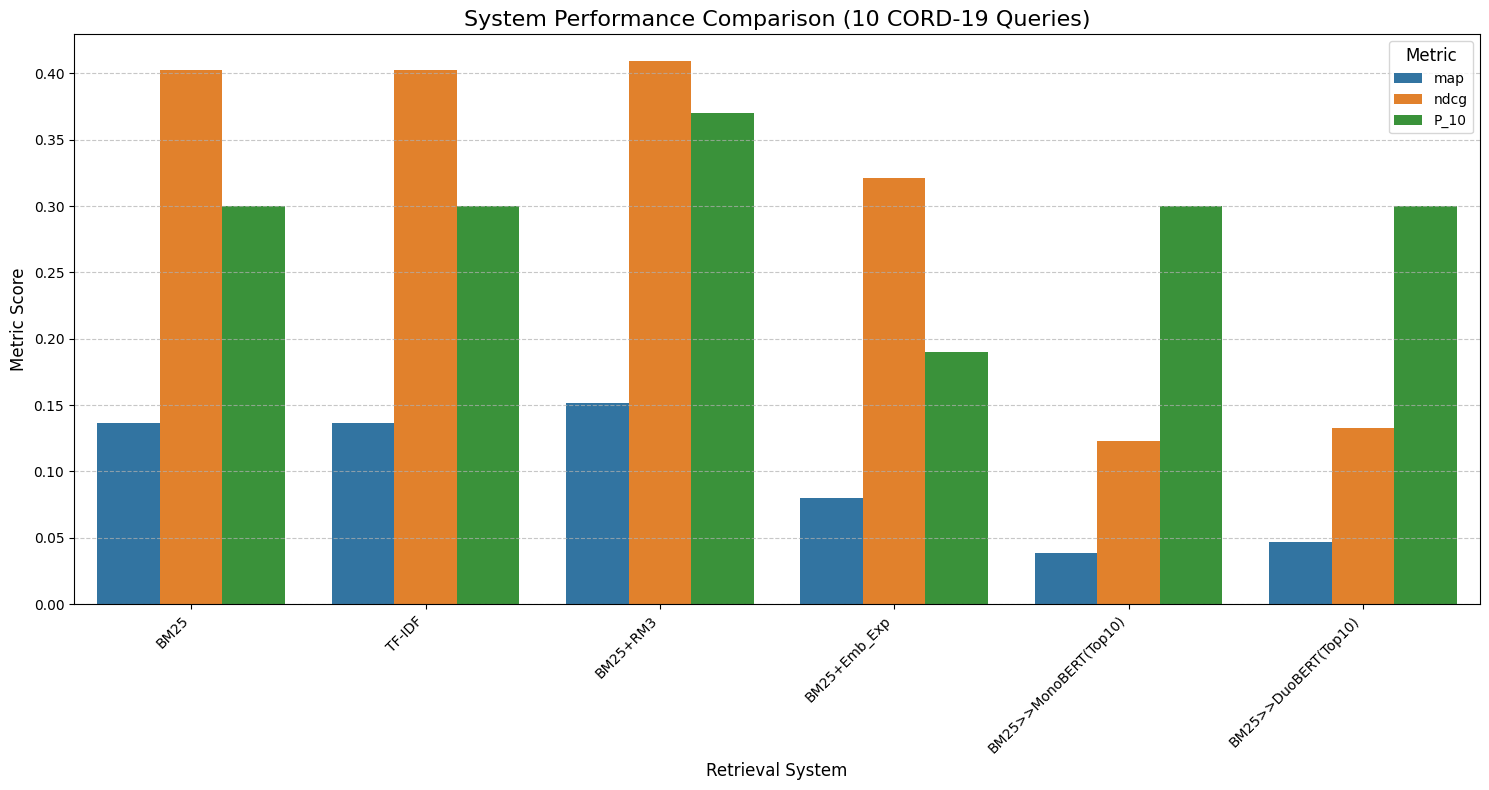

In [181]:
if not evaluation_results.empty:
    plt.figure(figsize=(15, 8))

    plot_metrics = [m for m in ["map", "ndcg", "P_10"] if m in evaluation_results.columns]

    if plot_metrics:
        num_eval_queries_for_plot = len(eval_queries_df_pt) if not eval_queries_df_pt.empty else 0

        plot_data = evaluation_results.melt(
            id_vars=['name'],
            value_vars=plot_metrics,
            var_name='Metric',
            value_name='Score'
        )


        ax = sns.barplot(x='name', y='Score', hue='Metric', data=plot_data)

        plt.xticks(rotation=45, ha="right", fontsize=10)
        plt.yticks(fontsize=10)

        plt.title(f'System Performance Comparison ({num_eval_queries_for_plot} CORD-19 Queries)', fontsize=16)
        plt.ylabel('Metric Score', fontsize=12)
        plt.xlabel('Retrieval System', fontsize=12)

        plt.legend(title='Metric', fontsize=10, title_fontsize=12, loc='upper right')

        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print("No standard metrics (map, ndcg, P_10) found in evaluation_results to plot.")

else:
    print("Evaluation results are empty, skipping plot generation.")

# Sample Query Demonstration

In [165]:
demo_systems = [bm25_retriever, tf_idf_retriever, bm25_rm3_pipeline, bm25_embedding_exp_pipeline, bm25_monobert_pipeline, bm25_duobert_pipeline]
demo_system_names = ["BM25", "TF-IDF", "BM25+RM3", "BM25+Emb_Exp", f"BM25>>MonoBERT(Top{CANDIDATES_FOR_RERANK_DEMO})", f"BM25>>DuoBERT(Top{CANDIDATES_FOR_RERANK_DEMO})"]
sample_query_text_demo = "long-term effects of COVID-19 vaccination"
if not queries_df_subset.empty and not (len(queries_df_subset)==1 and queries_df_subset.iloc[0]['qid'] == 'dummy_qid_final_ops'):
    sample_query_row_demo = queries_df_subset.iloc[0]
    sample_qid_demo, sample_query_text_demo = sample_query_row_demo['qid'], sample_query_row_demo['query']
    print(f"Using query_id '{sample_qid_demo}': '{sample_query_text_demo}' for demonstration.")
else:
    print(f"queries_df_subset empty or dummy. Using default demo query: '{sample_query_text_demo}'")

search_df_single_query = pd.DataFrame([{'qid': 'demo_q1', 'query': sample_query_text_demo}])
for name, pipeline in zip(demo_system_names, demo_systems):
    print(f"\n--- Top 3 results from {name} for query: '{sample_query_text_demo}' ---")
    start_time_s = time.time()
    if hasattr(pipeline, 'search') and callable(pipeline.search) and not isinstance(pipeline, (pt.Transformer, pt.apply.generic)):
        results_sample = pipeline.search(sample_query_text_demo)
    else:
        results_sample = pipeline.transform(search_df_single_query.copy())
    print(f"  (Query processing time: {time.time() - start_time_s:.4f}s)")

    if results_sample.empty: print("  No results returned."); continue
    for i_idx, row_series in results_sample.head(3).iterrows():
        docno, score = str(row_series['docno']), row_series.get('score', 'N/A')
        rank_val = row_series.get('rank', i_idx) + 1
        doc_text_series = documents_df_orig[documents_df_orig['docno'] == docno]['text']
        doc_text_orig = doc_text_series.iloc[0][:150]+"..." if not doc_text_series.empty else "Original text not found."
        score_display = f"{score:.4f}" if isinstance(score, (float, np.floating)) else str(score)
        print(f"  Rank {rank_val}. DocID: {docno} (Score: {score_display})\n     Content: {doc_text_orig}\n")

Using query_id 'dummy_q_eval_critical_final': 'dummy q final' for demonstration.

--- Top 3 results from BM25 for query: 'dummy q final' ---
  (Query processing time: 0.0951s)
  Rank 1. DocID: z8c37qvi (Score: 15.3091)
     Content: Watertight dural closure in brain surgery: a simple model for training. BACKGROUND To avoid cerebrospinal fluid leaks and related possible complicatio...

  Rank 2. DocID: nrgvmpv7 (Score: 13.2257)
     Content: Review of available methods of simulation training to facilitate surgical education. The old paradigm of "see one, do one, teach one" has now changed ...

  Rank 3. DocID: hf79cbuq (Score: 11.3030)
     Content: Effectiveness of surgical masks against influenza bioaerosols. BACKGROUND Most surgical masks are not certified for use as respiratory protective devi...


--- Top 3 results from TF-IDF for query: 'dummy q final' ---
  (Query processing time: 0.0983s)
  Rank 1. DocID: z8c37qvi (Score: 8.4851)
     Content: Watertight dural closure in brain s

In [ ]:
import gradio as gr
import pandas as pd
import time
import traceback
import matplotlib.pyplot as plt
import seaborn as sns

pipelines_global = {name: pipeline for name, pipeline in zip(demo_system_names, demo_systems)}
documents_df_orig_global = documents_df_orig.copy()
system_names_list_gradio = list(pipelines_global.keys())

def format_results_for_gradio(results_df, top_n):
    if results_df.empty: return pd.DataFrame(columns=["Rank", "DocID", "Score", "Content Snippet"])
    output_data = []
    for i, row in results_df.head(int(top_n)).iterrows():
        docno, score = str(row['docno']), row.get('score', 'N/A')
        rank = row.get('rank', i) + 1
        doc_text_series = documents_df_orig_global[documents_df_orig_global['docno'] == docno]['text']
        doc_snippet = doc_text_series.iloc[0][:250] + "..." if not doc_text_series.empty else "Snippet NA."
        score_str = f"{score:.4f}" if isinstance(score, (float, np.floating)) else str(score)
        output_data.append({"Rank": rank, "DocID": docno, "Score": score_str, "Content Snippet": doc_snippet})
    return pd.DataFrame(output_data)

def create_score_distribution_plot(results_df, top_n):
    fig = plt.figure(figsize=(8, 4))
    top_n = int(top_n)
    if results_df.empty or 'score' not in results_df.columns:
        plt.text(0.5, 0.5, "No scores to plot.", ha='center', va='center'); plt.axis('off'); return fig
    top_results = results_df.head(top_n).copy()
    top_results['numeric_score'] = pd.to_numeric(top_results['score'], errors='coerce').fillna(0)
    if top_results.empty or top_results['numeric_score'].isnull().all():
        plt.text(0.5, 0.5, "No valid numeric scores to plot.", ha='center', va='center'); plt.axis('off'); return fig
    top_results['display_rank'] = range(1, len(top_results) + 1)


    sns.barplot(x='display_rank', y='numeric_score', data=top_results, palette="viridis")

    plt.title(f'Score Distribution for Top {len(top_results)} Docs'); plt.xlabel('Document Rank'); plt.ylabel('Retrieval Score')
    plt.xticks(ticks=range(len(top_results)), labels=top_results['display_rank'], rotation=45, ha="right"); plt.tight_layout()
    return fig

def search_ir_system_gradio(query_text, system_name_selected, top_n_results_slider_val):
    top_n_results = int(top_n_results_slider_val)

    if not query_text:
        return pd.DataFrame(columns=["Rank", "DocID", "Score", "Content Snippet"]), \
               "Please enter a query.", "0.00s", None

    pipeline_to_run = pipelines_global[system_name_selected]
    search_df_single_query_gradio = pd.DataFrame([{'qid': 'gradio_q1', 'query': query_text}])
    plot_object = None

    try:
        start_time_s = time.time()
        if hasattr(pipeline_to_run, 'search') and callable(pipeline_to_run.search) and not isinstance(pipeline_to_run, (pt.Transformer, pt.apply.generic)):
            results_df = pipeline_to_run.search(query_text)
        else:
             results_df = pipeline_to_run.transform(search_df_single_query_gradio.copy())

        end_time_s = time.time()
        processing_time_str = f"{end_time_s - start_time_s:.2f}s"



        if results_df.empty:
            status_message = "No results found."
            output_df = pd.DataFrame(columns=["Rank", "DocID", "Score", "Content Snippet"])
        else:
            status_message = f"Displaying top {min(top_n_results, len(results_df))} results."
            output_df = format_results_for_gradio(results_df, top_n_results)

        plot_object = create_score_distribution_plot(results_df, top_n_results)

    except Exception as e:
        status_message = f"An error occurred: {str(e)}"
        output_df = pd.DataFrame(columns=["Rank", "DocID", "Score", "Content Snippet"])
        processing_time_str = "Error"

        fig_err = plt.figure(figsize=(8,4)); plt.text(0.5,0.5, "Error generating plot during exception.", ha='center', va='center'); plt.axis('off'); plot_object = fig_err
        print("Error during Gradio search:"); import traceback; traceback.print_exc()

    return output_df, status_message, processing_time_str, plot_object


default_gradio_query = sample_query_text_demo
gradio_examples_list = [
    ["effectiveness of masks against virus transmission", system_names_list_gradio[0] if system_names_list_gradio else "BM25", 5],
    ["COVID-19 vaccine development and trials", system_names_list_gradio[2] if len(system_names_list_gradio) > 2 else (system_names_list_gradio[0] if system_names_list_gradio else "BM25"), 3],
    ["long term effects of coronavirus", system_names_list_gradio[4] if len(system_names_list_gradio) > 4 else (system_names_list_gradio[0] if system_names_list_gradio else "BM25"), 5]
]
gradio_examples_list = [ex for ex in gradio_examples_list if ex[1] in system_names_list_gradio]


with gr.Blocks(theme=gr.themes.Soft(primary_hue="teal", secondary_hue="cyan")) as iface_colab_viz_cord19_final:
    gr.Markdown("# 📊 Interactive Information Retrieval System (CORD-19 Dataset)")
    gr.Markdown("Enter a query, select a retrieval system, and view ranked documents with score distributions.")
    with gr.Row():
        query_input_gradio = gr.Textbox(label="Query:", placeholder="e.g., covid transmission routes", value=default_gradio_query, scale=3)
        system_selector_gradio = gr.Dropdown(
            label="Retrieval System:",
            choices=system_names_list_gradio,
            value=system_names_list_gradio[0] if system_names_list_gradio else None,
            scale=2
        )
        top_n_slider_gradio = gr.Slider(
            minimum=1,
            maximum=max(1, CANDIDATES_FOR_RERANK_DEMO),
            value=5,
            step=1,
            label="Top N for Display/Plot",
            scale=1
        )

    search_button_gradio = gr.Button("Search & Visualize CORD-19 Data 📈", variant="primary")


    with gr.Row():
        status_output_gradio = gr.Textbox(label="Status:", interactive=False, scale=2)
        time_output_gradio = gr.Textbox(label="Time:", interactive=False, scale=1)

    gr.Markdown("---")

    with gr.Row():
        with gr.Column(scale=2):
            gr.Markdown("## 📜 Search Results (CORD-19 Documents)")
            results_table_gradio_out = gr.DataFrame(
                headers=["Rank", "DocID", "Score", "Content Snippet"],
                label="Ranked Documents",
                wrap=True,
                max_rows=CANDIDATES_FOR_RERANK_DEMO
            )
        with gr.Column(scale=1):
            gr.Markdown("## 📊 Score Distribution")
            score_plot_gradio_out = gr.Plot(label="Top Scores Distribution")

    search_button_gradio.click(
        fn=search_ir_system_gradio,
        inputs=[query_input_gradio, system_selector_gradio, top_n_slider_gradio],
        outputs=[results_table_gradio_out, status_output_gradio, time_output_gradio, score_plot_gradio_out]
    )

    if gradio_examples_list:
        gr.Examples(
            examples=gradio_examples_list,
            inputs=[query_input_gradio, system_selector_gradio, top_n_slider_gradio],

            outputs=[results_table_gradio_out, status_output_gradio, time_output_gradio, score_plot_gradio_out],
            fn=search_ir_system_gradio,
            cache_examples=False
        )
    else:
        gr.Markdown("_(No examples to display due to system configuration or empty example list)_")

iface_colab_viz_cord19_final.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://171f199cb3f5aaba33.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
